- **Tarea del backlog:** https://github.com/UCM-GIDIA-PD1/c2425-R4/issues/26.
- **Propósito del código:** Transformaciones y primer modelo regresión logística.  
- **Autor(es):** Francisco Pastor.  
- **Descripción y uso:** Ejecutar para ver resultado de modelo regresión logística en P2.
- **Estado actual:** En revisión.


# REGRESIÓN LOGÍSTICA

In [2]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, log_loss,confusion_matrix,make_scorer,f1_score
import seaborn as sns
from scipy.stats import uniform, loguniform

### Lectura de ficheros

En estas celdas se cargan los conjuntos de datos de entrenamiento y prueba, que están almacenados en formato Parquet. Para ello, se utilizan las rutas relativas para acceder a los archivos en el sistema de archivos. Se muestra el tamaño de ambos conjuntos.

In [3]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..","..", "data", "P2","train.parquet")
df_train= pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2010-01-02,Rashad Evans,Thiago Silva,False,0.40,0.36,0.3184,0.5992,0.2400,0.000,...,5.148266,13.544990,10,6,0.04,-0.2808,0.193548,-0.40,0.00,-18.84
1,2010-01-02,Sam Stout,Joe Lauzon,False,0.36,0.00,0.2724,0.4952,0.2400,0.744,...,0.000003,8.453161,7,6,0.36,-0.2228,-0.371306,-2.72,0.00,-101.68
2,2010-01-11,Rafael Dos Anjos,Kyle Bradley,False,0.00,0.00,0.3572,0.3156,0.3216,0.360,...,0.000011,10.000000,3,3,0.00,0.0416,0.086912,1.52,0.24,213.96
3,2010-01-11,Amir Sadollah,Brad Blackburn,False,0.00,1.84,0.4288,0.4464,0.0000,0.000,...,10.000000,11.547747,3,3,-1.84,-0.0176,0.000000,0.44,0.00,23.04
4,2010-01-11,Gray Maynard,Nate Diaz,False,0.00,0.00,0.3420,0.2928,0.6752,0.480,...,9.655488,12.609416,7,8,0.00,0.0492,0.328320,-0.52,-0.48,249.72


In [4]:
ruta_test =  os.path.join("..","..","..", "data", "P2","test.parquet")
df_test= pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2022-11-19,Kennedy Nzechukwu,Ion Cutelaba,False,0.00,0.40,0.4176,0.5208,0.2556,0.8640,...,86.483419,0.000000,7,13,-0.4,-0.1032,-0.110729,0.36,0.00,-39.60
1,2022-11-19,Vince Morales,Miles Johns,True,0.24,0.64,0.4028,0.4848,0.1000,0.0000,...,69.390238,54.933053,7,5,-0.4,-0.0820,0.153846,0.00,0.36,-52.16
2,2022-11-19,Andre Fialho,Muslim Salikhov,True,0.64,0.24,0.5220,0.4524,0.0000,0.2484,...,64.524204,127.265131,4,7,0.4,0.0696,-0.192661,0.00,0.00,-54.80
3,2022-11-19,Jennifer Maia,Maryna Moroz,False,0.00,0.00,0.3240,0.4880,0.0900,0.2480,...,15.229011,37.550440,9,9,0.0,-0.1640,-0.069020,-1.08,0.00,-340.04
4,2022-12-03,Eryk Anders,Kyle Daukaus,False,0.00,0.00,0.4532,0.5928,0.0432,0.2000,...,0.000000,58.874428,14,6,0.0,-0.1396,-0.158176,-1.68,0.40,189.72


## Preparación de conjuntos de entrenamiento y prueba

Se eliminan las columnas categóricas y la variable objetivo para la predicción (`DATE`, `Peleador_A`, `Peleador_B`, y `WINNER`) tanto del conjunto de entrenamiento (`df_train`) como del conjunto de prueba (`df_test`) para obtener las matrices de características `X_train` y `X_test`.  
A continuación, se define la variable objetivo (`y_train` y `y_test`) como la columna `WINNER`, que contiene el resultado del combate.  
Finalmente, se analiza la distribución de clases en ambos conjuntos para comprobar si están balanceados o si hay desbalance entre las clases (por ejemplo, si suele ganar más un peleador que otro).

In [5]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.56343
True     0.43657
Name: proportion, dtype: float64

In [6]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.546166
True     0.453834
Name: proportion, dtype: float64

## Mapa de calor de correlaciones entre variables

Se genera un mapa de calor para visualizar la **correlación absoluta** entre las variables predictoras en `X_train`, utilizando el coeficiente de **Spearman** (más robusto frente a relaciones no lineales).  

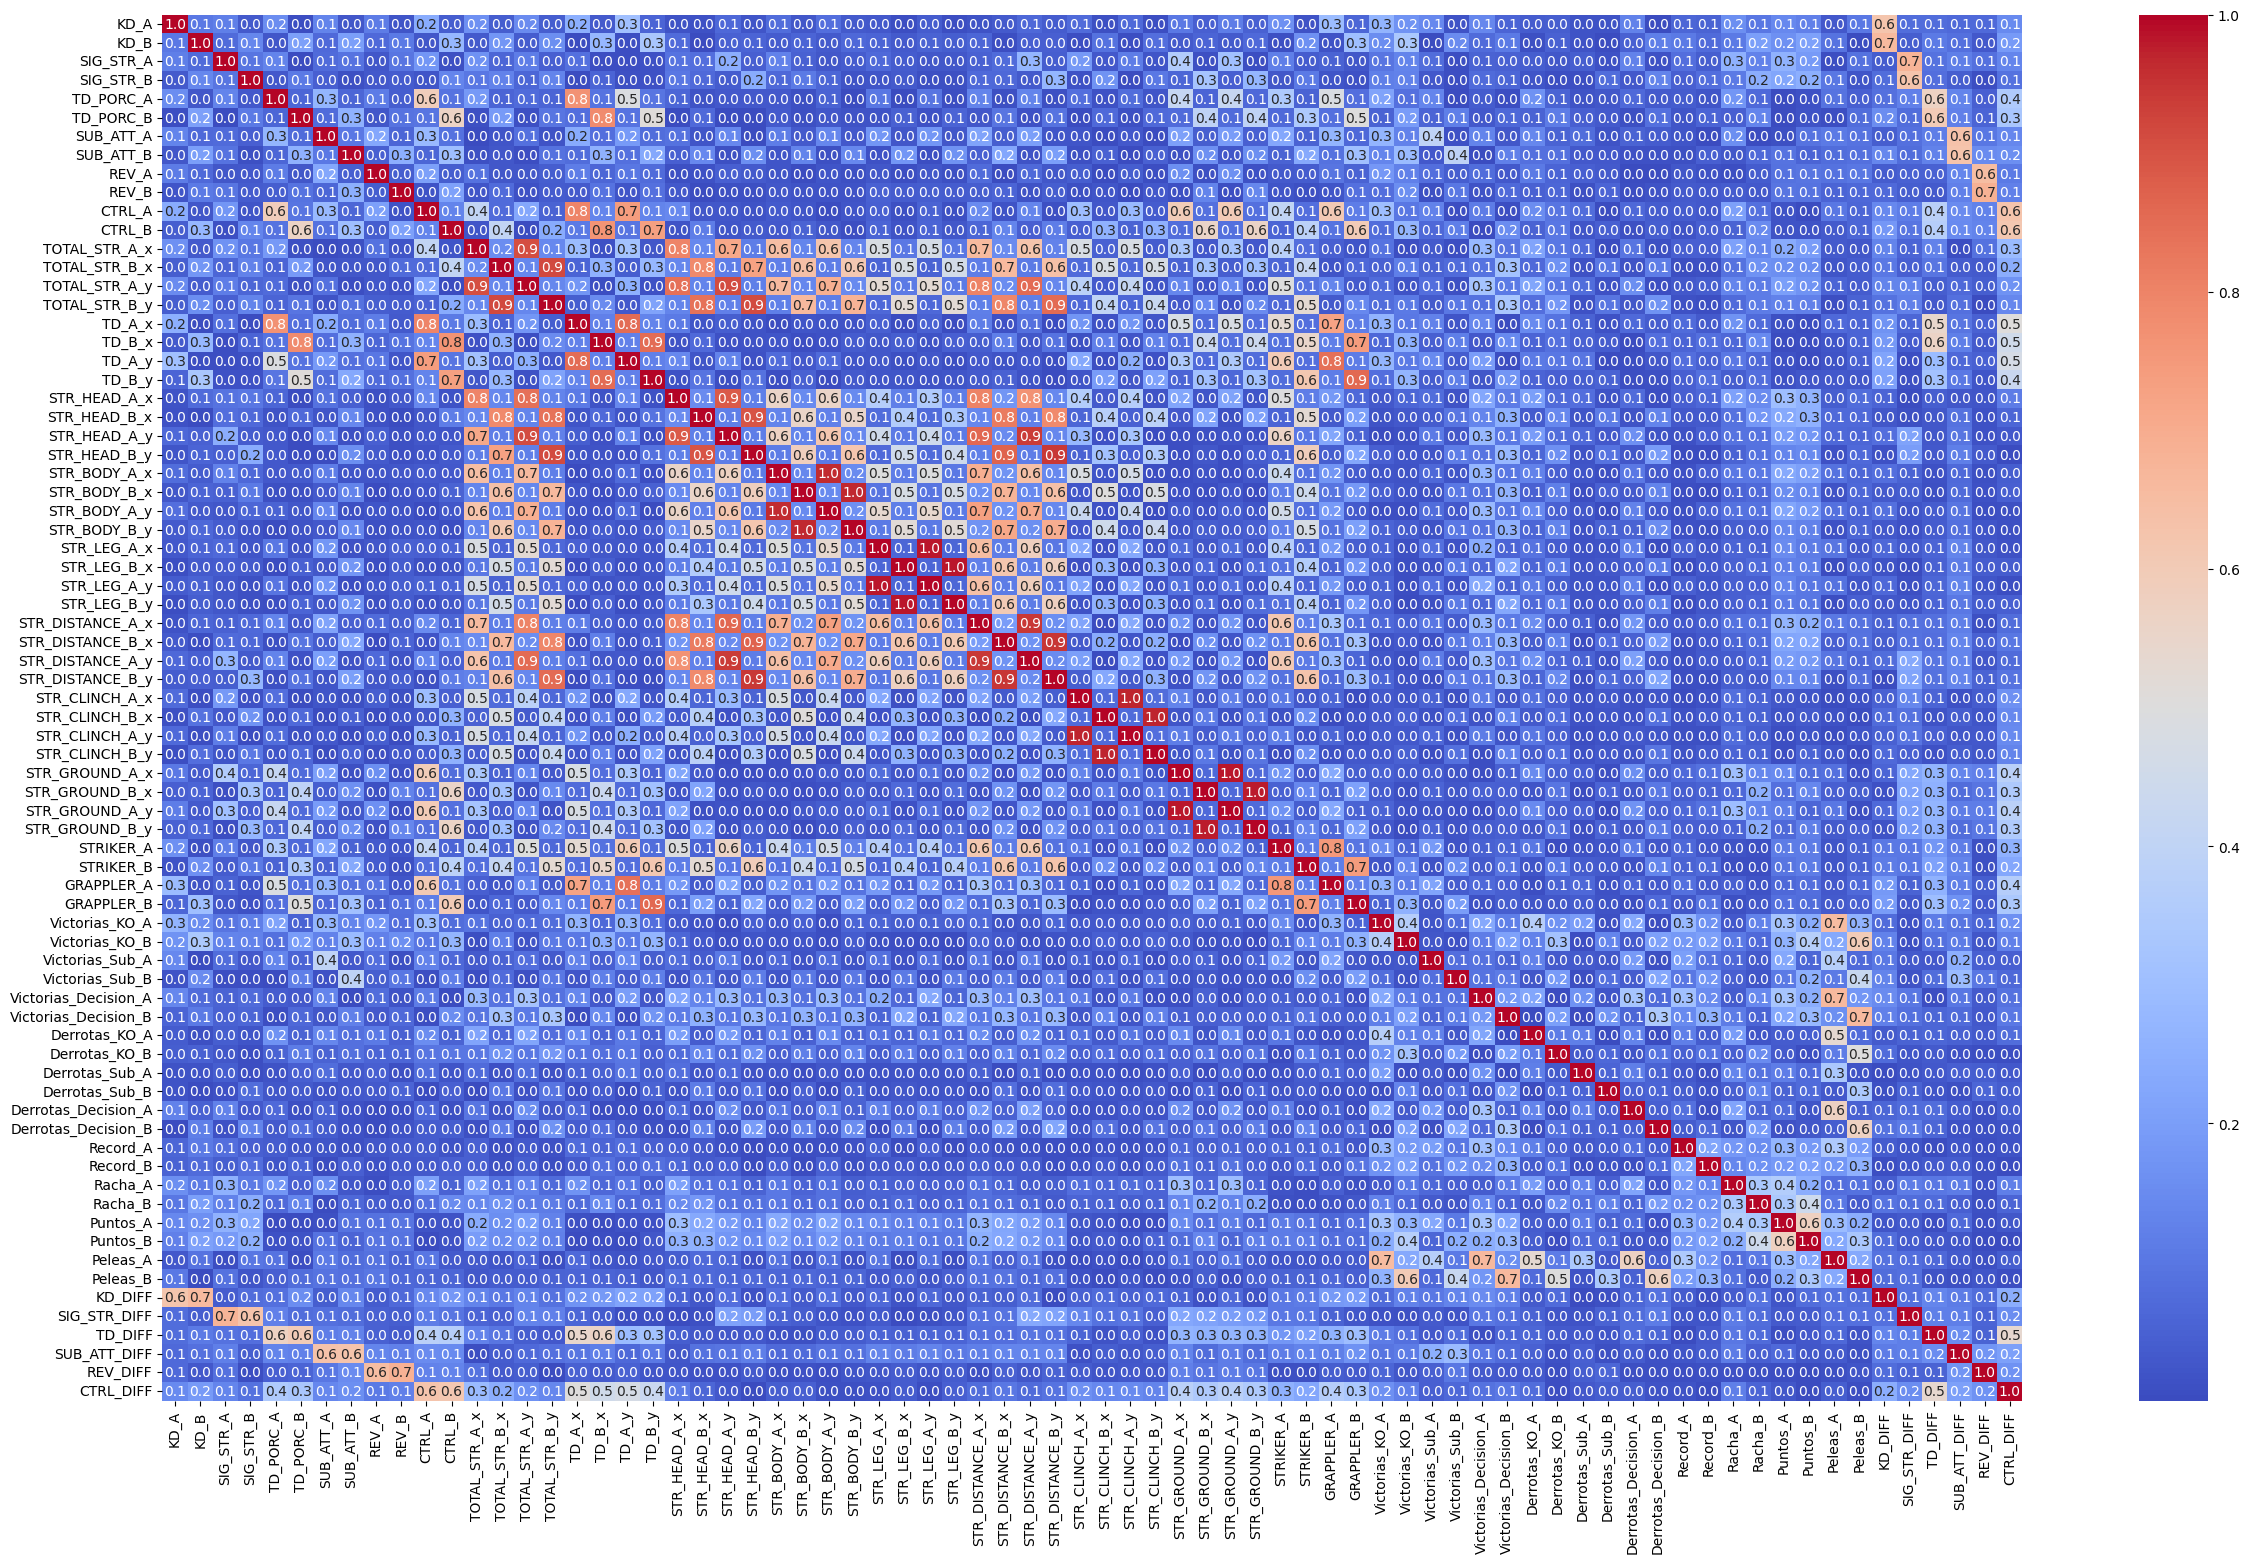

In [7]:

plt.figure(figsize=(30, 18))
sns.heatmap(X_train.corr(method="spearman").abs(), annot=True, cmap="coolwarm", fmt=".1f")
plt.show()

## Identificación de variables altamente correlacionadas

Se calcula la matriz de correlación de Spearman entre las variables de `X_train` y se identifican los pares de variables que tienen una **correlación absoluta mayor al umbral de 0.8** (indicando posible colinealidad). Usamos Spearman ya que es más adecuado para datos no lineales

In [8]:
correlation_matrix = X_train.corr(method='spearman')

umbral = 0.8
#Obtengo pares de variables con alta correlación (excluyendo la diagonal)
correlated_features = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

# Filtrar pares con correlación mayor al umbral
correlated_features.columns = ["Variable 1", "Variable 2", "Correlación"]
highly_correlated = correlated_features[abs(correlated_features["Correlación"]) > umbral]

# Mostrar todas las filas
pd.set_option('display.max_rows', None)
print("Variables altamente correlacionadas:\n", highly_correlated)

Variables altamente correlacionadas:
             Variable 1        Variable 2  Correlación
811      TOTAL_STR_A_x     TOTAL_STR_A_y     0.906941
817      TOTAL_STR_A_x      STR_HEAD_A_x     0.800278
872      TOTAL_STR_B_x     TOTAL_STR_B_y     0.916881
936      TOTAL_STR_A_y      STR_HEAD_A_x     0.842271
938      TOTAL_STR_A_y      STR_HEAD_A_y     0.913182
948      TOTAL_STR_A_y  STR_DISTANCE_A_x     0.801220
950      TOTAL_STR_A_y  STR_DISTANCE_A_y     0.854793
995      TOTAL_STR_B_y      STR_HEAD_B_x     0.837185
997      TOTAL_STR_B_y      STR_HEAD_B_y     0.912980
1009     TOTAL_STR_B_y  STR_DISTANCE_B_y     0.853677
1049            TD_A_x            TD_A_y     0.849116
1106            TD_B_x            TD_B_y     0.850212
1188            TD_A_y        GRAPPLER_A     0.840339
1243            TD_B_y        GRAPPLER_B     0.857543
1271      STR_HEAD_A_x      STR_HEAD_A_y     0.884260
1281      STR_HEAD_A_x  STR_DISTANCE_A_x     0.804185
1324      STR_HEAD_B_x      STR_HEAD_B_y    

## Eliminación de variables altamente correlacionadas

Tras calcular la matriz de correlación de Spearman y detectar pares de variables con una **correlación absoluta mayor a 0.8**, se decide eliminar algunas de ellas, ya que las variables X (Con éxito) e Y (Lanzados) está altamente correlacionadas y nos quedamos con solo una

Se eliminan 20 variables del conjunto de entrenamiento (`X_train`) y del conjunto de prueba (`X_test`).

In [9]:
correlacionadas=['TOTAL_STR_A_y','TOTAL_STR_B_y','TD_A_y', 'TD_B_y','GRAPPLER_A','GRAPPLER_B','STR_HEAD_A_y','STR_DISTANCE_A_x',
                 'STR_HEAD_B_y','STR_DISTANCE_B_x','STR_BODY_A_y','STR_BODY_B_y','STR_LEG_A_y','STR_LEG_B_y','STR_DISTANCE_A_y',
                 'STR_DISTANCE_B_y','STR_CLINCH_A_y','STR_CLINCH_B_y','STR_GROUND_A_y','STR_GROUND_B_y']

In [10]:
train_x2=X_train.drop(columns=correlacionadas)
test_x2=X_test.drop(columns=correlacionadas)

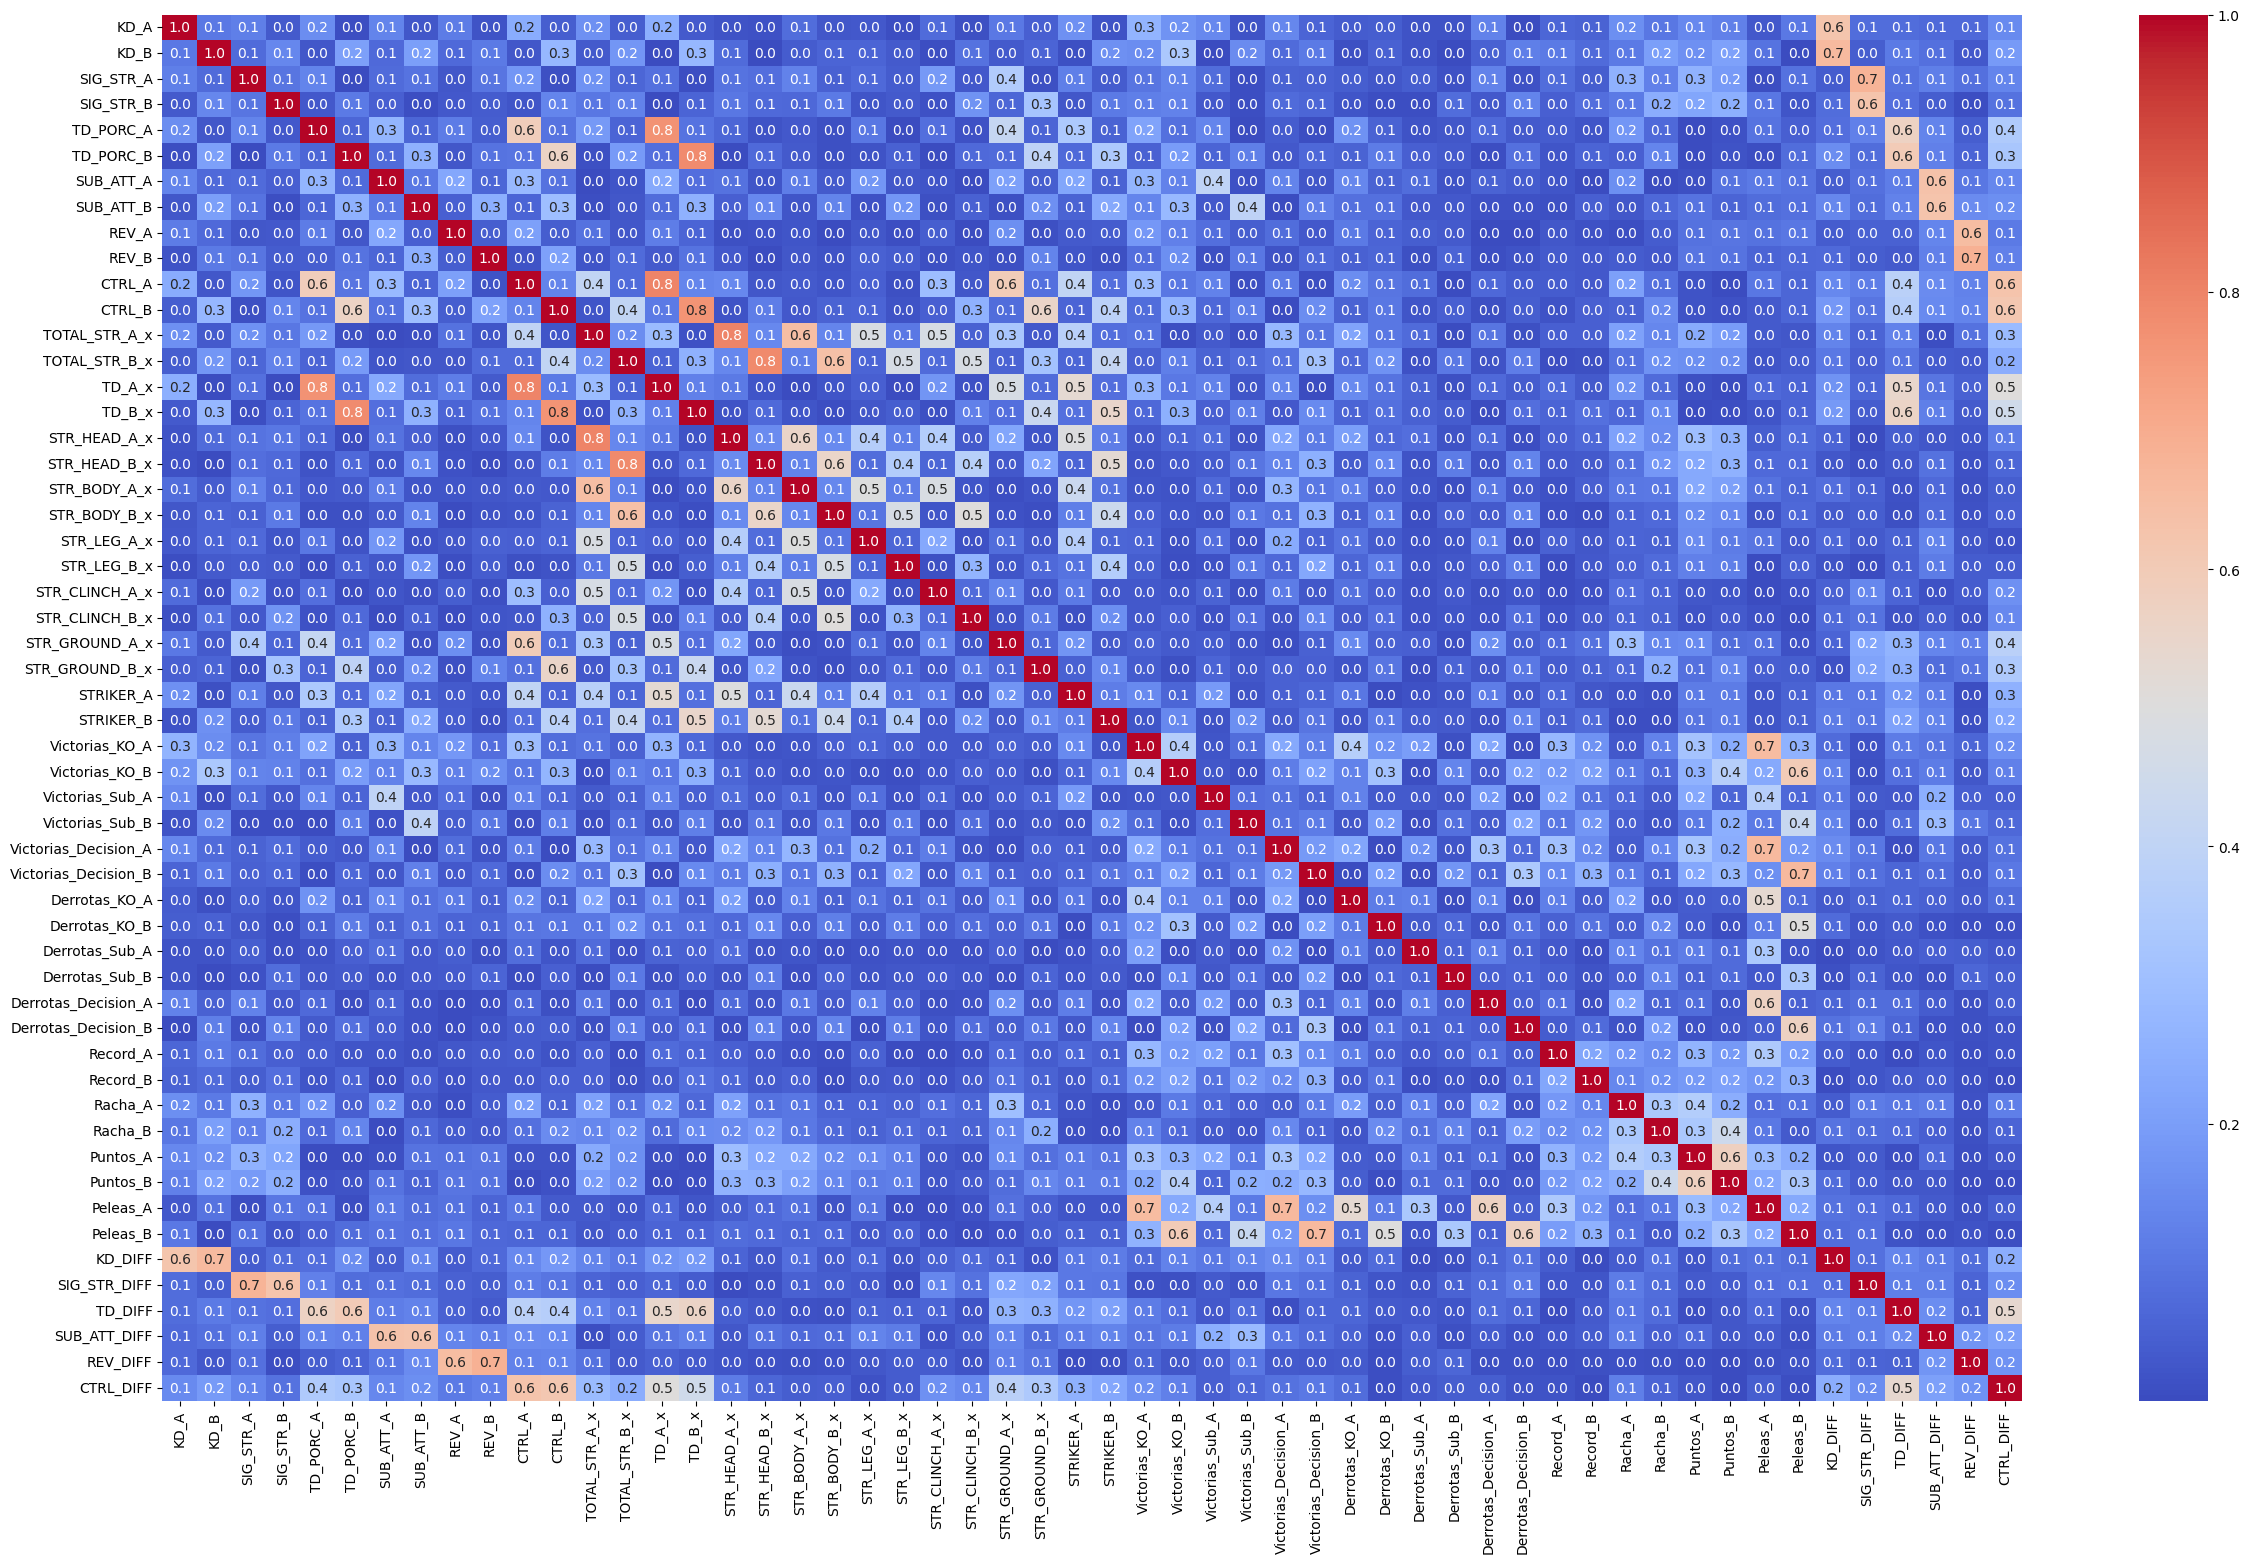

In [11]:
#Despues de eliminar correlaciones
plt.figure(figsize=(30, 18))
sns.heatmap(train_x2.corr(method="spearman").abs(), annot=True, cmap="coolwarm", fmt=".1f")
plt.show()

## Estadísticas descriptivas de las variables predictoras

Se visualizan estadísticas descriptivas del conjunto `train_x2` mediante el método `.describe()`. Este paso nos permite ver métricas como **count**, **mean**, **std**, **min, 25%, 50%, 75%, max**

In [12]:
train_x2.describe()

,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,SUB_ATT_A,SUB_ATT_B,REV_A,REV_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
count,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,...,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000
mean,0.267894,0.285153,0.456420,0.462313,0.272083,0.272953,0.365231,0.395098,0.112968,0.126844,...,40.515907,29.823266,10.303837,8.254503,-0.017259,-0.005893,0.002148,-0.029867,-0.013876,5.488755
std,0.340581,0.358011,0.104752,0.099625,0.220261,0.223596,0.504610,0.536374,0.235018,0.248473,...,63.417982,41.941885,6.028273,5.250206,0.471953,0.137393,0.238732,0.686974,0.336260,167.552652
min,0.000000,0.000000,0.079200,0.132000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,3.000000,-2.600000,-0.527200,-0.643678,-3.600000,-1.920000,-728.160000
25%,0.000000,0.000000,0.385300,0.393200,0.079200,0.072000,0.000000,0.000000,0.000000,0.000000,...,6.340797,4.081272,6.000000,4.000000,-0.240000,-0.099100,-0.173077,-0.360000,0.000000,-90.540000
50%,0.240000,0.240000,0.453800,0.461600,0.240000,0.240000,0.240000,0.240000,0.000000,0.000000,...,18.530769,14.030290,9.000000,7.000000,0.000000,-0.007000,0.000000,0.000000,0.000000,-1.960000
75%,0.400000,0.400000,0.522800,0.524800,0.404900,0.420000,0.600000,0.640000,0.000000,0.240000,...,51.176444,38.604258,14.000000,11.000000,0.240000,0.084300,0.163493,0.360000,0.000000,88.140000
max,2.200000,2.640000,0.888000,0.865600,1.000000,1.000000,3.440000,3.640000,2.240000,2.000000,...,683.477374,481.394415,39.000000,37.000000,2.200000,0.557600,0.741667,2.840000,2.240000,692.160000


## Escalado de variables con RobustScaler

Se aplica el escalado de características a `train_x2` y `test_x2` utilizando `RobustScaler`, que es especialmente útil cuando existen **valores atípicos** en los datos.

### ¿Por qué `RobustScaler`?
Para facilitar la convergencia del modelo, reducir los riesgos de sesgo y posteriormente poder comparar los coeficientes vamos a realizar un escalado robusto (`RobustScaler`). Elegimos este tipo de escalado porque los datos no siguen distribuciones normales y tienen mucha presencia de datos atípicos. 


Se utiliza el método `fit_transform()` en los datos de entrenamiento para ajustar y transformar los datos de prueba, y el método `transform()` en los datos de test para aplicar la misma transformación que ha sido aplicada al conjunto de prueba.

In [13]:
scaler = RobustScaler()
train_x3 = scaler.fit_transform(train_x2)
test_x3 = scaler.transform(test_x2)

## Conversión de arrays escalados a DataFrames

Tras escalar los datos con `RobustScaler`, los resultados (`train_x3` y `test_x3`) son arrays de NumPy. Para facilitar su análisis y mantener la trazabilidad de las variables se convierten nuevamente en DataFrames (`train_x3_df` y `test_x3_df`)

In [14]:
train_x3_df = pd.DataFrame(train_x3,columns=train_x2.columns)
test_x3_df = pd.DataFrame(test_x3,columns=test_x2.columns)

#Variables despues de la transformacion
train_x3_df.describe()

,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,SUB_ATT_A,SUB_ATT_B,REV_A,REV_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
count,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,...,2.554000e+03,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000
mean,0.069734,0.112882,0.019057,0.005420,0.098504,0.094694,0.208718,0.242340,0.112968,0.528517,...,4.903495e-01,0.457463,0.162980,0.179215,-0.035957,0.006037,0.006382,-0.041482,-0.013876,0.041688
std,0.851452,0.895028,0.761835,0.757030,0.676268,0.642517,0.841017,0.838084,0.235018,1.035305,...,1.414454e+00,1.214897,0.753534,0.750029,0.983235,0.749143,0.709309,0.954131,0.336260,0.937725
min,-0.600000,-0.600000,-2.724364,-2.504559,-0.736874,-0.689655,-0.400000,-0.375000,0.000000,0.000000,...,-4.133044e-01,-0.406404,-0.750000,-0.571429,-5.416667,-2.836423,-1.912464,-5.000000,-1.920000,-4.064249
25%,-0.600000,-0.600000,-0.498182,-0.519757,-0.493706,-0.482759,-0.400000,-0.375000,0.000000,0.000000,...,-2.718813e-01,-0.288185,-0.375000,-0.428571,-0.500000,-0.502181,-0.514237,-0.500000,0.000000,-0.495747
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.961404e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.400000,0.400000,0.501818,0.480243,0.506294,0.517241,0.600000,0.625000,0.000000,1.000000,...,7.281187e-01,0.711815,0.625000,0.571429,0.500000,0.497819,0.485763,0.500000,0.000000,0.504253
max,4.900000,6.000000,3.157818,3.069909,2.333436,2.183908,5.333333,5.312500,2.240000,8.333333,...,1.483076e+01,13.537767,3.750000,4.285714,4.583333,3.078517,2.203602,3.944444,2.240000,3.884710


## Selección de variables con RFECV y validación cruzada temporal

Se utiliza la técnica `RFECV` (*Recursive Feature Elimination with Cross-Validation*) para seleccionar automáticamente el subconjunto óptimo de variables predictoras.

### ¿Por qué `TimeSeriesSplit`?

En lugar de usar una validación cruzada tradicional (`KFold`), se aplica `TimeSeriesSplit`, ya que:

- El dataset tiene un componente **temporal/secuencial** ya que los datos de peleas están ordenados cronológicamente.
- Es importante evitar el **data leakage**, es decir, que el modelo entrene con datos del futuro para predecir el pasado.

In [15]:
def aplicarRFECV(X, Y):
    MIN_FEATURES = 5
    
    modelo = LogisticRegression(max_iter = 10000, class_weight="balanced", random_state=42)

    # Validación cruzada temporal
    cv = TimeSeriesSplit(n_splits=5)

    rfecv = RFECV(
        estimator=modelo,
        step=1,
        cv=cv,
        scoring="f1_weighted",
        min_features_to_select= MIN_FEATURES,
    )
    
    rfecv.fit(X,Y)
    
    # Si quieres obtener el valor maximo usar 'rfecv.n_features_'
    
    #Muestro grafico 
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure(figsize=(12, 6))
    plt.xlabel("Número de variables elegidas")
    plt.ylabel("f1-score")
    plt.xticks(range(0,len(X.columns),2))
    plt.errorbar(
        range(MIN_FEATURES, n_scores + MIN_FEATURES),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("RFE con validación cruzada")
    plt.show()
    
    return rfecv

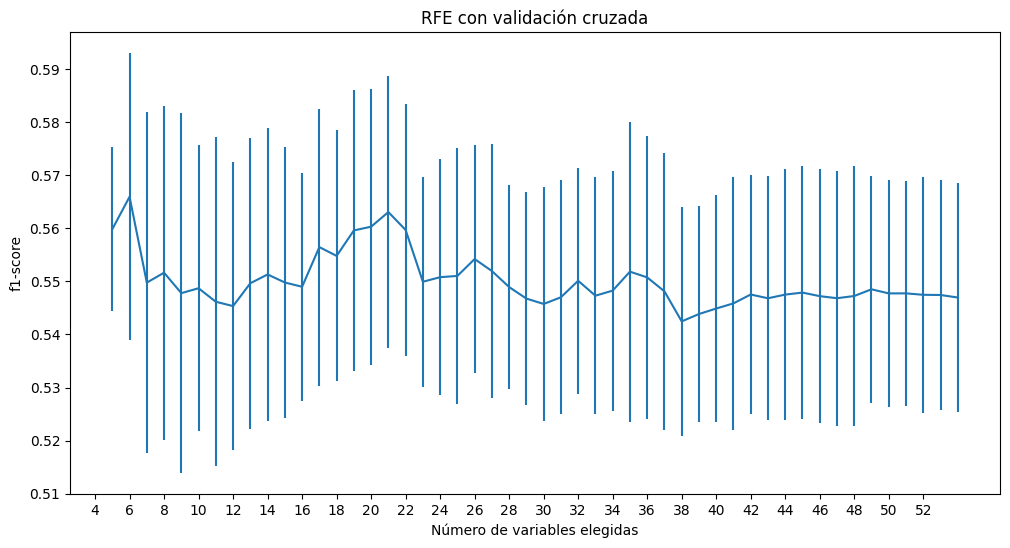

Variables seleccionadas:
['CTRL_A', 'Derrotas_KO_A', 'Derrotas_Decision_A', 'Racha_B', 'Peleas_A', 'REV_DIFF']


In [16]:
rfecv = aplicarRFECV(train_x3_df, y_train)
selected_features = train_x3_df.columns[rfecv.support_]

print("Variables seleccionadas:")
print(selected_features.tolist())

## Construcción del conjunto final de variables seleccionadas

A partir del proceso de selección con `RFECV`, se define manualmente un subconjunto de **6 variables** consideradas relevantes para el modelo final.  

In [17]:
train_x4=train_x3_df[['CTRL_A', 'Derrotas_KO_A', 'Derrotas_Decision_A', 'Racha_B', 'Peleas_A', 'REV_DIFF']]
test_x4=test_x3_df[['CTRL_A', 'Derrotas_KO_A', 'Derrotas_Decision_A', 'Racha_B', 'Peleas_A', 'REV_DIFF']]

## Función para realizar Grid Search con validación cruzada

Se define la función `realizarGridSearchCV()` para ejecutar una búsqueda de hiperparámetros mediante **Grid Search** con validación cruzada (`GridSearchCV`).

El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

In [18]:

f1_scorer = make_scorer(f1_score, average='weighted')

def realizarGridSearchCV(estimador, param, X, Y):
    """Realiza la estrategia de búsqueda Grid Search CV"""

    kf = TimeSeriesSplit(n_splits=5)  # Ahora sí, validación temporal
    grid_search = GridSearchCV(estimator=estimador, param_grid=param, cv=kf,
                            scoring=f1_scorer, refit = "f1_weighted", return_train_score=True, n_jobs=-1, error_score="raise")

    grid_search.fit(X, Y)
    
    return grid_search

## Función para realizar Randomized Search con validación cruzada

Se define la función `realizarRandomizedSearchCV()` para ejecutar una **búsqueda aleatoria de hiperparámetros** utilizando `RandomizedSearchCV`.

Diferencias entre RandomizedSearch y GridSearch:


| Característica                      | GridSearchCV                                                | RandomizedSearchCV                                           |
|------------------------------------|--------------------------------------------------------------|--------------------------------------------------------------|
| **Tipo de búsqueda**               | Exhaustiva: prueba **todas** las combinaciones posibles     | Aleatoria: prueba un **subconjunto aleatorio** de combinaciones |
| **Cobertura del espacio**          | Completa                                                    | Parcial, depende del número de iteraciones (`n_iter`)       |
| **Tiempo de cómputo**              | Alto (exponencial si hay muchos parámetros)                 | Bajo (más eficiente en espacios grandes)                    |
| **Uso recomendado**                | Cuando el espacio de búsqueda es **pequeño y acotado**      | Cuando hay muchos parámetros o rangos **continuos/amplios** |
| **Flexibilidad**                   | Menos flexible: requiere listas fijas de valores            | Muy flexible: acepta **distribuciones** (`uniform`, `loguniform`, etc.) |
| **Probabilidad de encontrar el óptimo global** | Alta si el espacio está bien definido                       | Menor, pero puede cubrir más terreno en menos tiempo        |

In [19]:
def realizarRandomizedSearchCV(estimador, param, X, Y):
    """Realiza la estrategia de búsqueda Grid Search CV"""
    kf = TimeSeriesSplit(n_splits=5)
    randomized_search = RandomizedSearchCV(estimator=estimador, param_distributions=param, cv=kf,
                            scoring=f1_scorer, refit = "f1_weighted", return_train_score=True, n_jobs=-1, error_score="raise")

    randomized_search.fit(X, Y)
    
    return randomized_search

## Búsqueda de hiperparámetros para Regresión Logística (ElasticNet)

Se realiza una búsqueda de hiperparámetros utilizando tanto **Grid Search** como **Randomized Search**, con validación cruzada de 5 particiones, para un modelo de `LogisticRegression` con regularización `elasticnet`.

In [20]:
# Cuadrícula de hiperparámetros
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'class_weight': [None, 'balanced', class_weight_dict],
    'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

param_distributions = {
    'C': loguniform(1e-4, 1e4),  # distribución logarítmica entre 0.0001 y 10000
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'class_weight': [None, 'balanced', class_weight_dict],
    'l1_ratio': uniform(0.0, 1.0)  # continuo entre 0 y 1
}

modelo = LogisticRegression(random_state=42, max_iter=500)

grid_search = realizarGridSearchCV(modelo, param_grid, train_x4, y_train)

modelo_final_grid = grid_search.best_estimator_
cv_results_grid = grid_search.cv_results_
best_params_grid = grid_search.best_params_


random_search = realizarRandomizedSearchCV(modelo, param_distributions, train_x4, y_train)

modelo_final_random = random_search.best_estimator_
cv_results_random = random_search.cv_results_
best_params_random = random_search.best_params_


## Función para evaluar el modelo en el conjunto de prueba

Se define `evaluarModelo()` para analizar el rendimiento de un modelo de clasificación sobre datos de prueba (`test_x`, `test_y`).


In [21]:
def evaluarModelo(modelo,test_x,test_y):

    # Predicciones
    pred_y = modelo.predict(test_x)              # Predicción de clases
    prob_y = modelo.predict_proba(test_x)[:, 1]  # Probabilidad de la clase positiva

    # Cálculo de métricas
    accuracy = accuracy_score(test_y, pred_y)
    f1_val = f1_score(test_y, pred_y)
    roc_auc_val = roc_auc_score(test_y, prob_y)
    precision_val = precision_score(test_y, pred_y)
    recall_val = recall_score(test_y, pred_y)
    log_loss_val = log_loss(test_y, prob_y)

    # Imprimir métricas
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1_val:.4f}")
    print(f"AUC-ROC: {roc_auc_val:.4f}")
    print(f"Precisión: {precision_val:.4f}")
    print(f"Sensibilidad (Recall): {recall_val:.4f}")
    print(f"Log-loss: {log_loss_val:.4f}")
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(test_y, pred_y)

    # Visualizar la matriz de confusión
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

## Evaluación del modelo con hiperparámetros ajustados mediante GridSearchCV

Se evaluó el rendimiento del mejor modelo obtenido con GridSearch sobre el conjunto de prueba (`test_x4`, `y_test`).


El modelo tiene una **tendencia a predecir más la Clase 1**, lo cual puede estar influido por el balance de clases y la métrica de optimización (F1 ponderado).

> Nota: aunque el `f1_score` no es muy alto, el modelo muestra cierto poder de discriminación (AUC ~0.61), lo que indica que con ajustes adicionales o más datos, puede mejorarse.


-- Métricas del modelo con hiperparámetros ajustados mediante GridSearchCV --
Accuracy: 0.5822
F1-Score: 0.5822
AUC-ROC: 0.6162
Precisión: 0.5330
Sensibilidad (Recall): 0.6414
Log-loss: 0.6765


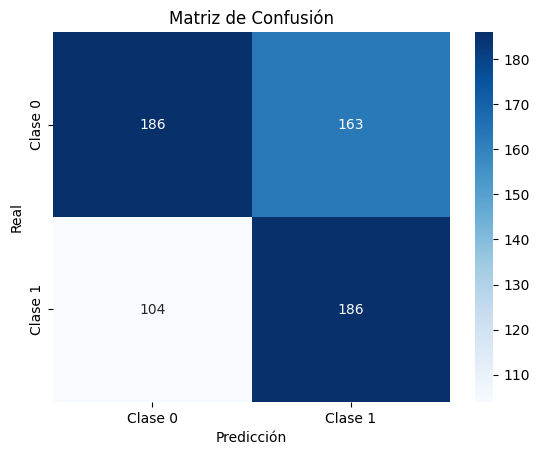

In [22]:
print("\n-- Métricas del modelo con hiperparámetros ajustados mediante GridSearchCV --")
evaluarModelo(modelo_final_grid,test_x4,y_test)       #Con 41 variables (rfecv.n_features_)

## Evaluación del modelo con hiperparámetros ajustados mediante RandomizedSearchCV

Se evaluó el modelo ajustado con `RandomizedSearchCV` sobre el conjunto de prueba (`test_x4`, `y_test`).


-- Métricas del modelo con hiperparámetros ajustados mediante RandomizedSearchCV --
Accuracy: 0.5743
F1-Score: 0.5737
AUC-ROC: 0.6157
Precisión: 0.5259
Sensibilidad (Recall): 0.6310
Log-loss: 0.6762


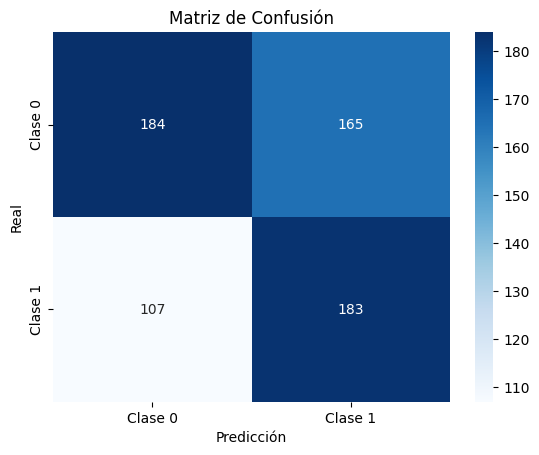

In [23]:
print("\n-- Métricas del modelo con hiperparámetros ajustados mediante RandomizedSearchCV --")
evaluarModelo(modelo_final_random,test_x4,y_test)    

## Comparativa entre Grid Search y Randomized Search

- Ambos modelos presentan **resultados muy similares**, con un rendimiento ligeramente superior por parte de Grid Search en todas las métricas clave, aunque las diferencias no son significativas.
- Cualquiera de los dos puede considerarse como modelo final, aunque Grid Search habría explorado más combinaciones, a costa de mayor tiempo de cómputo.